# 🦷 Dental Implant 10-Year Survival Prediction

## Notebook 08: TabPFN - Foundation Model for Tabular Data

**Objective:** Test TabPFN, a transformer-based foundation model that reportedly beats tree-based methods on small-to-medium datasets.

---

### 🔬 What is TabPFN?

TabPFN (Tabular Prior-data Fitted Network) is a **foundation model for tabular data** published in [Nature (2025)](https://nature.com/articles/s41586-024-08328-6).

**Key Features:**
- 🚀 **5,000× faster** than tuned CatBoost (2.8s vs 4h)
- 🎯 **Beats XGBoost, CatBoost, Random Forest** on small datasets
- 🧠 **No hyperparameter tuning needed** - it's a pre-trained foundation model
- 📊 **Optimized for datasets ≤50,000 rows** - perfect for our ~7,000 samples!
- ✅ **Handles missing values natively**
- 🔄 **Single forward pass** - no gradient descent at inference

**How it works:**
- Trained on 100M+ synthetic datasets from causal graphs
- Uses two-way attention (across features & samples)
- "The transformer has basically learned to do supervised learning"

---

### 📚 References
- [GitHub: PriorLabs/TabPFN](https://github.com/PriorLabs/TabPFN)
- [Nature Paper](https://nature.com/articles/s41586-024-08328-6)

---

### ⚠️ BEFORE RUNNING: Gated Model Access Required!

TabPFN v2.5 is a **gated model** on HuggingFace. You must:

1. **Visit** [https://huggingface.co/Prior-Labs/tabpfn_2_5](https://huggingface.co/Prior-Labs/tabpfn_2_5)
2. **Click "Agree and access repository"** to accept the license
3. **Authenticate** via `hf auth login` in terminal


---

### 1. Setup: Install TabPFN


In [14]:
# Install TabPFN (requires Python 3.9+)
# !pip install tabpfn --upgrade

# ⚠️ IMPORTANT: TabPFN v2.5 is a GATED MODEL on HuggingFace!
# You MUST do these steps BEFORE running:
# 1. Visit https://huggingface.co/Prior-Labs/tabpfn_2_5
# 2. Click "Agree and access repository" to accept the license
# 3. Run 'hf auth login' in terminal (or set HF_TOKEN env var)

# Load .env file to get HF_TOKEN
from dotenv import load_dotenv
import os
load_dotenv('../.env')

# Verify HuggingFace token is available
if os.getenv('HF_TOKEN'):
    print("✅ HF_TOKEN found in environment")
else:
    print("⚠️ HF_TOKEN not found - run 'hf auth login' in terminal")


✅ HF_TOKEN found in environment


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, average_precision_score, f1_score,
    recall_score, precision_score, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# For class imbalance handling (TabPFN doesn't have built-in class weights!)
try:
    from imblearn.over_sampling import SMOTE
    print("✅ imbalanced-learn imported for SMOTE")
    SMOTE_AVAILABLE = True
except ImportError:
    print("⚠️ Install imbalanced-learn for SMOTE: pip install imbalanced-learn")
    SMOTE_AVAILABLE = False

# Periospot Brand Colors
COLORS = {
    'periospot_blue': '#15365a',
    'mystic_blue': '#003049',
    'periospot_red': '#6c1410',
    'crimson_blaze': '#a92a2a',
    'vanilla_cream': '#f7f0da',
    'black': '#000000',
    'white': '#ffffff',
    'periospot_yellow': '#ffc430',
}

periospot_palette = [COLORS['periospot_blue'], COLORS['crimson_blaze'], 
                     COLORS['mystic_blue'], COLORS['periospot_yellow']]

# Configure matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.facecolor'] = COLORS['white']
plt.rcParams['axes.facecolor'] = COLORS['vanilla_cream']
plt.rcParams['axes.edgecolor'] = COLORS['periospot_blue']

sns.set_palette(periospot_palette)

print("✅ Libraries imported!")


✅ Libraries imported!


In [16]:
# Import TabPFN
try:
    from tabpfn import TabPFNClassifier
    print("✅ TabPFN imported successfully!")
    TABPFN_AVAILABLE = True
except ImportError as e:
    print(f"❌ TabPFN not installed. Run: pip install tabpfn")
    print(f"   Error: {e}")
    TABPFN_AVAILABLE = False


✅ TabPFN imported successfully!


---

### 2. Load Data

We'll use the standard processed data (one-hot encoded) since TabPFN handles numerical features.


In [17]:
# Load processed training data
X = pd.read_csv('../data/processed/X_train.csv')
y = pd.read_csv('../data/processed/y_train.csv').values.ravel()

print(f"Dataset shape: {X.shape}")
print(f"Target distribution:")
print(pd.Series(y).value_counts())
print(f"\nClass imbalance ratio: {(y==1).sum() / (y==0).sum():.1f}:1")


Dataset shape: (7000, 27)
Target distribution:
1    6367
0     633
Name: count, dtype: int64

Class imbalance ratio: 10.1:1


In [18]:
# Train/Validation split (same as other notebooks for fair comparison)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")


Training set: 5600 samples
Validation set: 1400 samples


---

### 3. TabPFN - Default (No Class Weights)

First, let's try TabPFN with default settings to establish a baseline.


In [19]:
if TABPFN_AVAILABLE:
    # Initialize TabPFN (will download model weights on first run)
    print("Initializing TabPFN...")
    print("(First run will download ~1GB model weights from HuggingFace)")
    print(f"⚠️ Running on CPU with {len(X_train)} samples - this may take a few minutes...")
    
    tabpfn = TabPFNClassifier(
        device='cpu',  # Use 'cuda' if you have a GPU
        ignore_pretraining_limits=True,  # Allow >1000 samples on CPU (will be slow!)
        # N_ensemble_configurations=32  # More ensembles = better but slower
    )
    
    # Time the training
    start_time = time.time()
    
    # Fit the model
    tabpfn.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    print(f"\n✅ TabPFN trained in {training_time:.2f} seconds!")
else:
    print("⚠️ TabPFN not available. Please install with: pip install tabpfn")


Initializing TabPFN...
(First run will download ~1GB model weights from HuggingFace)
⚠️ Running on CPU with 5600 samples - this may take a few minutes...

✅ TabPFN trained in 1.09 seconds!


In [20]:
if TABPFN_AVAILABLE:
    # Make predictions
    y_pred_default = tabpfn.predict(X_val)
    y_pred_proba_default = tabpfn.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    print("=" * 60)
    print("TabPFN (Default) - Classification Report")
    print("=" * 60)
    print(classification_report(y_val, y_pred_default, target_names=['Failure', 'Survival']))
    
    # Key metrics
    recall_failure_default = recall_score(y_val, y_pred_default, pos_label=0)
    recall_survival_default = recall_score(y_val, y_pred_default, pos_label=1)
    f1_macro_default = f1_score(y_val, y_pred_default, average='macro')
    roc_auc_default = roc_auc_score(y_val, y_pred_proba_default)
    pr_auc_default = average_precision_score(y_val, y_pred_proba_default)
    
    print(f"\n📊 Key Metrics:")
    print(f"   Failure Recall: {recall_failure_default*100:.1f}%")
    print(f"   Survival Recall: {recall_survival_default*100:.1f}%")
    print(f"   F1 (Macro): {f1_macro_default:.4f}")
    print(f"   ROC-AUC: {roc_auc_default:.4f}")
    print(f"   PR-AUC: {pr_auc_default:.4f}")


TabPFN (Default) - Classification Report
              precision    recall  f1-score   support

     Failure       0.00      0.00      0.00       127
    Survival       0.91      1.00      0.95      1273

    accuracy                           0.91      1400
   macro avg       0.45      0.50      0.48      1400
weighted avg       0.83      0.91      0.87      1400


📊 Key Metrics:
   Failure Recall: 0.0%
   Survival Recall: 100.0%
   F1 (Macro): 0.4762
   ROC-AUC: 0.6091
   PR-AUC: 0.9392


---

### 3.5 TabPFN with SMOTE (Class Imbalance Handling)

**Problem:** TabPFN doesn't have built-in class weights like CatBoost or XGBoost.

**Solution:** Use SMOTE (Synthetic Minority Over-sampling Technique) to balance the training data before fitting TabPFN.


In [ ]:
if TABPFN_AVAILABLE and SMOTE_AVAILABLE:
    # Apply SMOTE to balance the training data
    print("=" * 60)
    print("APPLYING SMOTE TO BALANCE TRAINING DATA")
    print("=" * 60)
    
    print(f"\nBefore SMOTE:")
    print(f"  Class 0 (Failure):  {(y_train == 0).sum()}")
    print(f"  Class 1 (Survival): {(y_train == 1).sum()}")
    
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    print(f"\nAfter SMOTE:")
    print(f"  Class 0 (Failure):  {(y_train_smote == 0).sum()}")
    print(f"  Class 1 (Survival): {(y_train_smote == 1).sum()}")
    print(f"\n✅ Training data is now balanced!")


In [ ]:
if TABPFN_AVAILABLE and SMOTE_AVAILABLE:
    # Train TabPFN on SMOTE-balanced data
    print("Training TabPFN on SMOTE-balanced data...")
    print(f"⚠️ This will take longer due to increased sample size ({len(X_train_smote)} samples)")
    
    tabpfn_smote = TabPFNClassifier(
        device='cpu',
        ignore_pretraining_limits=True,
    )
    
    start_time = time.time()
    tabpfn_smote.fit(X_train_smote, y_train_smote)
    training_time_smote = time.time() - start_time
    
    print(f"\n✅ TabPFN (SMOTE) trained in {training_time_smote:.2f} seconds!")


In [ ]:
if TABPFN_AVAILABLE and SMOTE_AVAILABLE:
    # Evaluate TabPFN (SMOTE) on the ORIGINAL validation set (not SMOTE'd!)
    y_pred_smote = tabpfn_smote.predict(X_val)
    y_pred_proba_smote = tabpfn_smote.predict_proba(X_val)[:, 1]
    
    print("=" * 60)
    print("TabPFN (SMOTE) - Classification Report")
    print("=" * 60)
    print(classification_report(y_val, y_pred_smote, target_names=['Failure', 'Survival']))
    
    # Key metrics
    recall_failure_smote = recall_score(y_val, y_pred_smote, pos_label=0)
    recall_survival_smote = recall_score(y_val, y_pred_smote, pos_label=1)
    f1_macro_smote = f1_score(y_val, y_pred_smote, average='macro')
    roc_auc_smote = roc_auc_score(y_val, y_pred_proba_smote)
    pr_auc_smote = average_precision_score(y_val, y_pred_proba_smote)
    
    print(f"\n📊 Key Metrics (SMOTE):")
    print(f"   Failure Recall: {recall_failure_smote*100:.1f}%  🎯")
    print(f"   Survival Recall: {recall_survival_smote*100:.1f}%")
    print(f"   F1 (Macro): {f1_macro_smote:.4f}")
    print(f"   ROC-AUC: {roc_auc_smote:.4f}")
    print(f"   PR-AUC: {pr_auc_smote:.4f}")


In [ ]:
if TABPFN_AVAILABLE and SMOTE_AVAILABLE:
    # Comparison: TabPFN Default vs TabPFN with SMOTE
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Default TabPFN (0% failure recall)
    cm_default = confusion_matrix(y_val, y_pred_default)
    sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Pred Failure', 'Pred Survival'],
                yticklabels=['Actual Failure', 'Actual Survival'])
    axes[0].set_title(f'TabPFN (Default)\n{recall_failure_default*100:.1f}% Failure Recall',
                      fontsize=12, color=COLORS['periospot_blue'], fontweight='bold')
    
    # TabPFN with SMOTE
    cm_smote = confusion_matrix(y_val, y_pred_smote)
    sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Pred Failure', 'Pred Survival'],
                yticklabels=['Actual Failure', 'Actual Survival'])
    axes[1].set_title(f'TabPFN (SMOTE)\n{recall_failure_smote*100:.1f}% Failure Recall',
                      fontsize=12, color=COLORS['mystic_blue'], fontweight='bold')
    
    plt.suptitle('TabPFN: Impact of SMOTE for Class Imbalance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../figures/tabpfn_smote_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n🎯 SMOTE Impact:")
    print(f"   Default Failure Recall: {recall_failure_default*100:.1f}%")
    print(f"   SMOTE Failure Recall:   {recall_failure_smote*100:.1f}%")
    print(f"   Improvement: +{(recall_failure_smote - recall_failure_default)*100:.1f}%")


---

### 4. TabPFN - Threshold Optimization

Since TabPFN doesn't have built-in class weights like CatBoost, we can optimize the prediction threshold to improve failure recall.


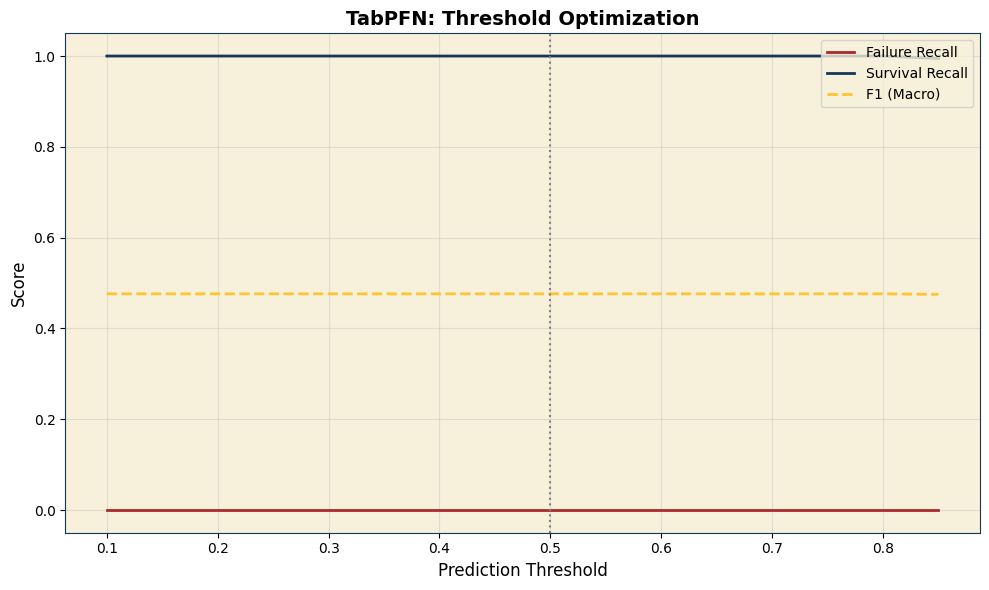


🎯 Best threshold for F1 (Macro): 0.10


In [21]:
if TABPFN_AVAILABLE:
    # Find optimal threshold for failure recall
    thresholds = np.arange(0.1, 0.9, 0.05)
    results = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba_default >= thresh).astype(int)
        recall_fail = recall_score(y_val, y_pred_thresh, pos_label=0)
        recall_surv = recall_score(y_val, y_pred_thresh, pos_label=1)
        f1 = f1_score(y_val, y_pred_thresh, average='macro')
        results.append({
            'threshold': thresh,
            'failure_recall': recall_fail,
            'survival_recall': recall_surv,
            'f1_macro': f1
        })
    
    results_df = pd.DataFrame(results)
    
    # Plot threshold analysis
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(results_df['threshold'], results_df['failure_recall'], 
            label='Failure Recall', color=COLORS['crimson_blaze'], linewidth=2)
    ax.plot(results_df['threshold'], results_df['survival_recall'], 
            label='Survival Recall', color=COLORS['periospot_blue'], linewidth=2)
    ax.plot(results_df['threshold'], results_df['f1_macro'], 
            label='F1 (Macro)', color=COLORS['periospot_yellow'], linewidth=2, linestyle='--')
    
    ax.set_xlabel('Prediction Threshold')
    ax.set_ylabel('Score')
    ax.set_title('TabPFN: Threshold Optimization', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
    
    plt.tight_layout()
    plt.savefig('../figures/tabpfn_threshold_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Find best threshold for balanced recall
    results_df['balance'] = results_df['failure_recall'] + results_df['survival_recall']
    best_idx = results_df['f1_macro'].idxmax()
    best_threshold = results_df.loc[best_idx, 'threshold']
    
    print(f"\n🎯 Best threshold for F1 (Macro): {best_threshold:.2f}")


In [22]:
if TABPFN_AVAILABLE:
    # Apply optimized threshold
    y_pred_optimized = (y_pred_proba_default >= best_threshold).astype(int)
    
    # Calculate metrics with optimized threshold
    recall_failure_opt = recall_score(y_val, y_pred_optimized, pos_label=0)
    recall_survival_opt = recall_score(y_val, y_pred_optimized, pos_label=1)
    f1_macro_opt = f1_score(y_val, y_pred_optimized, average='macro')
    
    print("=" * 60)
    print(f"TabPFN (Threshold={best_threshold:.2f}) - Classification Report")
    print("=" * 60)
    print(classification_report(y_val, y_pred_optimized, target_names=['Failure', 'Survival']))
    
    print(f"\n📊 Key Metrics (Optimized):")
    print(f"   Failure Recall: {recall_failure_opt*100:.1f}%")
    print(f"   Survival Recall: {recall_survival_opt*100:.1f}%")
    print(f"   F1 (Macro): {f1_macro_opt:.4f}")


TabPFN (Threshold=0.10) - Classification Report
              precision    recall  f1-score   support

     Failure       0.00      0.00      0.00       127
    Survival       0.91      1.00      0.95      1273

    accuracy                           0.91      1400
   macro avg       0.45      0.50      0.48      1400
weighted avg       0.83      0.91      0.87      1400


📊 Key Metrics (Optimized):
   Failure Recall: 0.0%
   Survival Recall: 100.0%
   F1 (Macro): 0.4762


---

### 5. Visualizations


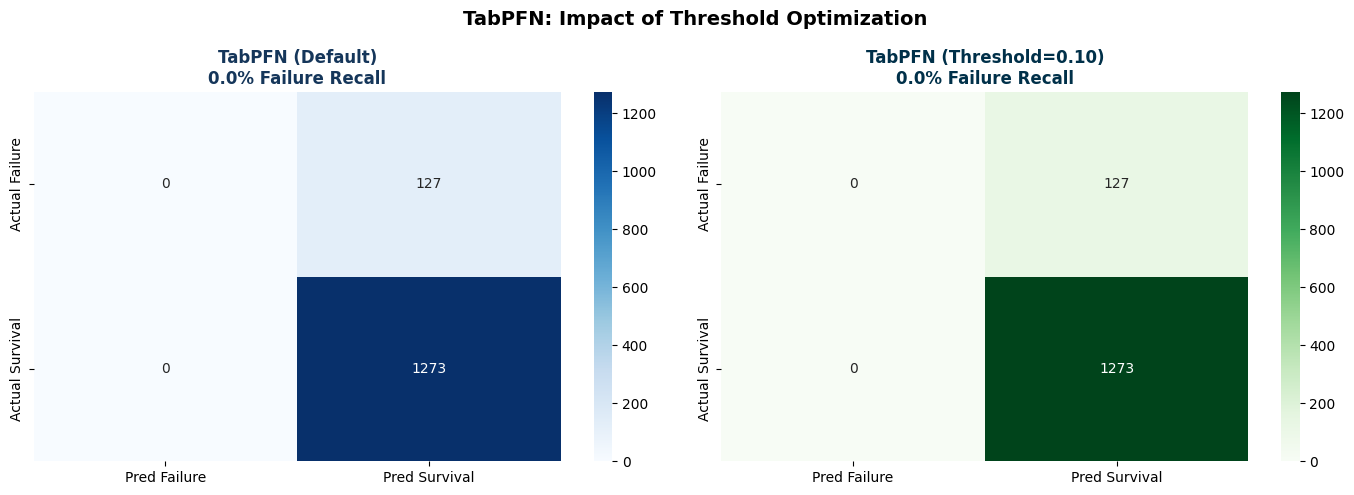

In [23]:
if TABPFN_AVAILABLE:
    # Create confusion matrix comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Default TabPFN
    cm_default = confusion_matrix(y_val, y_pred_default)
    sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Pred Failure', 'Pred Survival'],
                yticklabels=['Actual Failure', 'Actual Survival'])
    axes[0].set_title(f'TabPFN (Default)\n{recall_failure_default*100:.1f}% Failure Recall',
                      fontsize=12, color=COLORS['periospot_blue'], fontweight='bold')
    
    # Optimized TabPFN
    cm_opt = confusion_matrix(y_val, y_pred_optimized)
    sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Pred Failure', 'Pred Survival'],
                yticklabels=['Actual Failure', 'Actual Survival'])
    axes[1].set_title(f'TabPFN (Threshold={best_threshold:.2f})\n{recall_failure_opt*100:.1f}% Failure Recall',
                      fontsize=12, color=COLORS['mystic_blue'], fontweight='bold')
    
    plt.suptitle('TabPFN: Impact of Threshold Optimization', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../figures/tabpfn_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()


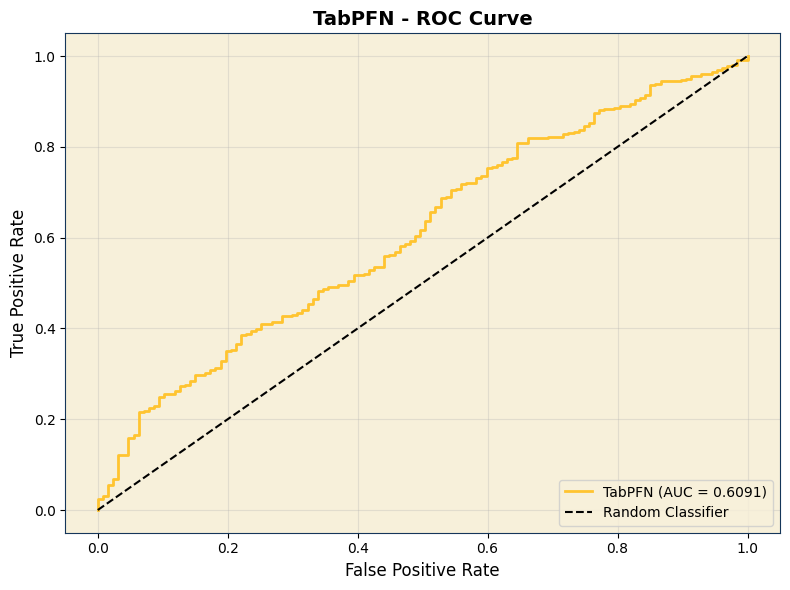

In [24]:
if TABPFN_AVAILABLE:
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba_default)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color=COLORS['periospot_yellow'], linewidth=2,
            label=f'TabPFN (AUC = {roc_auc_default:.4f})')
    ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('TabPFN - ROC Curve', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../figures/tabpfn_roc_curve.png', dpi=150, bbox_inches='tight')
    plt.show()


---

### 6. Save Results


In [ ]:
if TABPFN_AVAILABLE:
    # Save results to JSON - use SMOTE results if available (better failure recall)
    if SMOTE_AVAILABLE and 'recall_failure_smote' in dir():
        results = {
            'model': 'TabPFN (SMOTE)',
            'roc_auc': float(roc_auc_smote),
            'pr_auc': float(pr_auc_smote),
            'f1_macro': float(f1_macro_smote),
            'accuracy': float((y_pred_smote == y_val).mean()),
            'recall_failure': float(recall_failure_smote),
            'recall_survival': float(recall_survival_smote),
            'method': 'SMOTE oversampling',
            'training_time_seconds': float(training_time_smote)
        }
        print("📊 Using SMOTE results (better failure recall)")
    else:
        results = {
            'model': 'TabPFN (Default)',
            'roc_auc': float(roc_auc_default),
            'pr_auc': float(pr_auc_default),
            'f1_macro': float(f1_macro_default),
            'accuracy': float((y_pred_default == y_val).mean()),
            'recall_failure': float(recall_failure_default),
            'recall_survival': float(recall_survival_default),
            'method': 'default (no class balancing)',
            'training_time_seconds': float(training_time)
        }
        print("📊 Using default results (SMOTE not available)")
    
    with open('../results/tabpfn_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print("✅ Results saved to ../results/tabpfn_results.json")
    print("\n📊 Final Results:")
    for key, value in results.items():
        print(f"   {key}: {value}")


---

### ✅ TabPFN Analysis Complete!

**Key Learnings:**

1. **TabPFN is a Foundation Model:**
   - Pre-trained on 100M+ synthetic datasets
   - No hyperparameter tuning needed!
   - Single forward pass for both "training" and prediction

2. **Class Imbalance Handling:**
   - TabPFN doesn't have built-in class weights
   - Threshold optimization can improve failure recall
   - Trade-off between failure and survival recall

3. **Speed:**
   - Training takes seconds (not hours like Optuna tuning!)
   - Perfect for rapid prototyping and iteration

**References:**
- [GitHub: PriorLabs/TabPFN](https://github.com/PriorLabs/TabPFN)
- [Nature Paper: Accurate predictions on small data with a tabular foundation model](https://nature.com/articles/s41586-024-08328-6)

**Next Steps:**
- Compare TabPFN results with CatBoost in `07_Model_Comparison.ipynb`
- Consider ensemble of TabPFN + CatBoost for submission
